<H1 align="center"> Duckweed Detection based on YOLO v5</H1> 

# Load dataset and libraries

In [ ]:
# Clone the Yolov5 model 
!git clone https://github.com/ultralytics/yolov5  

!pip install -U -r yolov5/requirements.txt  
!pip install utils 
!pip install -q wandb

Cloning into 'yolov5'...
remote: Enumerating objects: 14654, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 14654 (delta 0), reused 1 (delta 0), pack-reused 14650
Receiving objects: 100% (14654/14654), 13.73 MiB | 35.79 MiB/s, done.
Resolving deltas: 100% (10085/10085), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 182 kB 4.6 MB/s 
     |████████████████████████████████| 761 kB 81.6 MB/s 
     |████████████████████████████████| 9.4 MB 73.3 MB/s 
     |████████████████████████████████| 17.3 MB 76.6 MB/s 
     |████████████████████████████████| 3.2 MB 83.3 MB/s 
     |████████████████████████████████| 280 kB 62.0 MB/s 
     |████████████████████████████████| 62 kB 1.7 MB/s 
     |████████████████████████████████| 33.8 MB 100.0 MB/s 
     |██████████████████████████████  | 834.1 MB 143.5 MB/s eta 0:00:01tcmalloc: large alloc 114

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 4.5 MB/s 
     |████████████████████████████████| 173 kB 91.1 MB/s 
     |████████████████████████████████| 140 kB 89.4 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires ipython~=7.9.0, but you have ipython 8.7.0 which is incompatible.


In [ ]:
from google.colab import drive
import gdown
import time
import shutil
import os 
from pathlib import Path
import pandas as pd
import cv2
import random
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from PIL import Image, ImageOps, ImageDraw
import numpy as np
import pickle
import torch
from IPython.display import Image # for displaying images
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import glob
from IPython.display import Image, display
import wandb
import importlib

print("Done")

Done


In [ ]:
# Mount Gdrive
drive.mount('/content/gdrive')

# Weights & Biases 
wandb.login()

Mounted at /content/gdrive


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

Download the dataset and sort files to improve its accessibility.

In [ ]:
GDRIVE_DATASET_PATH = "/content/gdrive/Shareddrives/Recycling Rush - Datasets ♻️/datasets/duckweed_dataset.zip"
LOCAL_DATASET_PATH = "/content/duckweed_dataset/" # folder for the dataset

%cd /content/
if os.path.exists(LOCAL_DATASET_PATH):
  shutil.rmtree(LOCAL_DATASET_PATH)
os.mkdir(LOCAL_DATASET_PATH)

!unzip "$GDRIVE_DATASET_PATH" -d "$LOCAL_DATASET_PATH" > /dev/null

dataset = pd.read_csv(LOCAL_DATASET_PATH+"info.csv", index_col=0) 
dataset.rename(columns = {'label':'xml'}, inplace = True)

print("Done")

/content
Done


In [ ]:
dataset

image              txt              xml  instances
0        images/0.jpg     labels/0.txt     labels/0.xml          4
1        images/1.jpg     labels/1.txt     labels/1.xml          1
2        images/2.jpg     labels/2.txt     labels/2.xml          6
3        images/3.jpg     labels/3.txt     labels/3.xml         14
4        images/4.jpg     labels/4.txt     labels/4.xml          1
...               ...              ...              ...        ...
3330  images/3330.jpg  labels/3330.txt  labels/3330.xml         14
3331  images/3331.jpg  labels/3331.txt  labels/3331.xml         10
3332  images/3332.jpg  labels/3332.txt  labels/3332.xml         14
3333  images/3333.jpg  labels/3333.txt  labels/3333.xml          1
3334  images/3334.jpg  labels/3334.txt  labels/3334.xml          4

[3335 rows x 4 columns]

In [ ]:
def find_object_distribution(dataset, name):

  classes = {}
  for idx, sample in tqdm(dataset.iterrows(), total=len(dataset)):
    with open(LOCAL_DATASET_PATH+dataset.at[idx,"txt"]) as txt:
      lines = txt.readlines()
      for line in lines: 
        label = line.split(" ")[0]

        if label not in classes.keys(): 
          classes[label] = 1
        else: 
          classes[label] += 1

  print("Category Distribution for Objects in "+name)
  for key, value in classes.items():
    print("-> ",key, ': ', value)
  
find_object_distribution(dataset, "Augmented Dataset")

  0%|          | 0/3335 [00:00<?, ?it/s]

Category Distribution for Objects in Augmented Dataset
->  0 :  16629


Visualize some samples

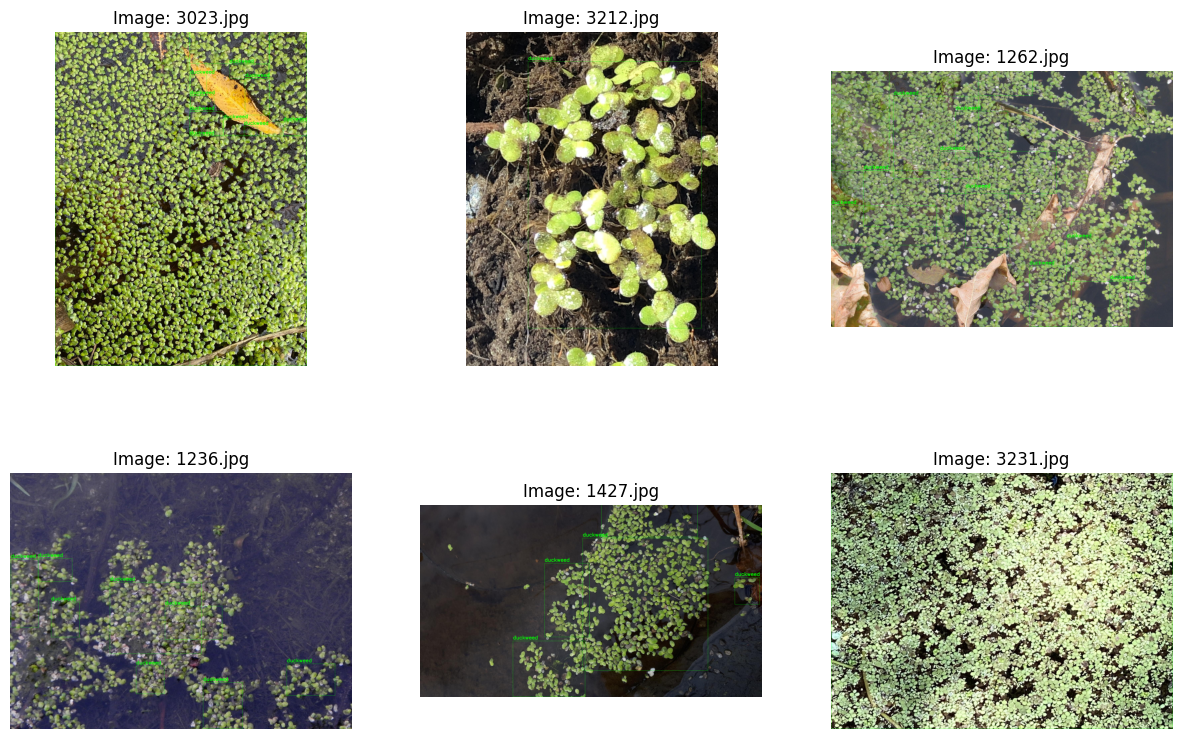

In [ ]:
# Show n samples with TXT annotations
def show_samples_txt(dataset, classes, number): 

  images = {}
  for i in range(number):
    index = random.randint(0,len(dataset)-1)
    image = cv2.imread(LOCAL_DATASET_PATH+dataset.at[index,"image"])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    height, width, _ = image.shape

    with open(LOCAL_DATASET_PATH+dataset.at[index,"txt"]) as txt:
      for line in txt.readlines():
        if line == "\n":
          break

        # line = txt.readline()
        id = line.split(" ")[0]
        if len(id) > 0:
          id = int(id)
          label = classes[id]
          x=float(line.split(" ")[1])
          y=float(line.split(" ")[2])
          w=float(line.split(" ")[3])
          h=float(line.split(" ")[4])

          # Convert Yolo format to rectangular coordinates
          l = int((x - w / 2) * width)
          r = int((x + w / 2) * width)
          t = int((y - h / 2) * height)
          b = int((y + h / 2) * height)

          if l < 0:
            l = 0
          if r > width - 1:
            r = width - 1
          if t < 0:
            t = 0
          if b > height - 1:
            b = height - 1

          font = cv2.FONT_HERSHEY_SIMPLEX
          # Put text
          cv2.putText(image, label,(l,t-10),font,1,(0,255,0),2,cv2.LINE_AA)
          # Draw bounding box
          cv2.rectangle(image, (l, t), (r, b), (0,255,0), 1)
    images[dataset.at[index,"image"]] = image

    subplot = 0
    plt.rcParams["figure.figsize"] = (15,20) 
    for key, value in images.items():
      plt.subplot(4,3,subplot+1)
      plt.axis('off')
      plt.title('Image: '+key.split("/")[1])
      plt.imshow(value)
      subplot +=1

number_of_samples = 6 

show_samples_txt(dataset, {0:"duckweed"}, number_of_samples)

# Implement YOLO v5

## 1. Split the dataset
Split the dataset into train, validation, and test sets containing 70%, 20%, and 10% of the data, respectively. 

In [ ]:
%cd "$LOCAL_DATASET_PATH"

# Read images and annotations
images = [os.path.join(LOCAL_DATASET_PATH+'images/', x) for x in os.listdir(LOCAL_DATASET_PATH+'images') if x[-3:] == "jpg"]
annotations = [os.path.join(LOCAL_DATASET_PATH+'labels/', x) for x in os.listdir(LOCAL_DATASET_PATH+'labels') if x[-3:] == "txt"]

images.sort()
annotations.sort()

# Split the dataset into train-valid-test splits 
train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.3, random_state = 1)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.33, random_state = 1)

# Create the folders to keep the splits
!mkdir train test val train/images train/labels test/images test/labels val/images val/labels 

# Utility function to move images/labels to their respective datasets
def move_files_to_folder(list_of_files, destination_folder):
  for f in list_of_files:
    try:
      shutil.copy(f, destination_folder)
    except:
      print(f)
      assert False

# Move the splits into their folders
move_files_to_folder(train_images, 'train/images/')
move_files_to_folder(val_images, 'val/images/')
move_files_to_folder(test_images, 'test/images/')
move_files_to_folder(train_annotations, 'train/labels/')
move_files_to_folder(val_annotations, 'val/labels/')
move_files_to_folder(test_annotations, 'test/labels/')

# shutil.rmtree(LOCAL_DATASET_PATH+"images")
# shutil.rmtree(LOCAL_DATASET_PATH+"labels")

/content/duckweed_dataset


## 2. Especify model parameters and architecture 



<img src="https://user-images.githubusercontent.com/26833433/103595982-ab986000-4eb1-11eb-8c57-4726261b0a88.png" width="500" align="center" />

 

In [ ]:
# Access the yolov5 folder and show the model's architecture
%cd /content/yolov5
%cat /content/yolov5/models/yolov5m.yaml

/content/yolov5
# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 0.67  # model depth multiple
width_multiple: 0.75  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4],

In [ ]:
# Check if we're using torch with GPU
print('Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Using torch 1.13.1+cu117 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)


In [ ]:
# Details for the dataset you want to train your model on are defined by the data config YAML file. 

# Define the number of classes
num_classes = 1

# IPython is a great tool for interactive shells as Notebooks. It comes with 
# many utilities and we will use register_line_cell_magic
# to overwrite a file directly from a Colab cell. Otherwise, we would need to 
# download and upload the file. We define writetemplate to customize iPython 
# writefile 
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [ ]:
# Change the location of the training and validation subsets. The rest
# of the file remains equal. 

%%writetemplate data.yaml

train: /content/duckweed_dataset/train/images
val: /content/duckweed_dataset/val/images
test: /content/duckweed_dataset/test/images

nc: 1
names: ['duckweed']

In [ ]:
%cat data.yaml


train: /content/duckweed_dataset/train/images
val: /content/duckweed_dataset/val/images
test: /content/duckweed_dataset/test/images

nc: 1
names: ['duckweed']


In [ ]:
# change the number of classes defined in the yolo v5 architectures. the rest remains the same. 
%%writetemplate /content/yolov5/models/custom_yolov5m.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.67  # model depth multiple
width_multiple: 0.75  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C3, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, C3, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, C3, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

In [ ]:
%cat models/custom_yolov5m.yaml


# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 1  # number of classes
depth_multiple: 0.67  # model depth multiple
width_multiple: 0.75  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]]

## 3. Train the model
Training with Yolov5 can be done by using a script named `train.py`, which will require the following parameters:

* **img:** input image size (width == height)
* **batch:** batch size
* **epochs:** number of training epochs. 
* **data:** path to our yaml file
* **cfg:** model configuration
* **weights:** custom path to save the best weights. 
* **name:** output file with metric results
* **nosave:** boolean that specifies to only save the final checkpoint
* **cache:** boolean that specifies to cache images for faster training

In [ ]:
# Path for the checkpoints
checkpoints_path = "/content/gdrive/Shareddrives/Recycling Rush - Datasets ♻️/experiments/yolov5s"

# Number of epochs
EPOCHS = 100

BATCH_SIZE = 16

In [ ]:
%cd /content/yolov5/
!python train.py --img 720 --batch "$BATCH_SIZE" --epochs "$EPOCHS" --data './data.yaml' --weights yolov5s.pt --project "$checkpoints_path" --name "yolov5m_initialdataset" 

## 4. Inference
Yolov5 comes with the `detect.py` file, which is able to use the best checkpoint and detect damages in images of a selected folder. This file requires the following parameters:
- **source:** folder with the images to predict. source can also point out to a single image, a video, and a webcam. 
- **weights:** path to the checkpoint you want to use
- **conf-thres:** confidence threshold
- **project:** save results to project/name
- **name:** save results to project/name

Apart from a folder of images, there are other sources we can use for our detector as well. The command syntax for doing so is described by the following.



```
python detect.py --source 0  # webcam
                            file.jpg  # image 
                            file.mp4  # video
                            path/  # directory
                            path/*.jpg  # glob
                            rtsp://170.93.143.139/rtplive/470011e600ef003a004ee33696235daa  # rtsp stream
                            rtmp://192.168.1.105/live/test  # rtmp stream
                            http://112.50.243.8/PLTV/88888888/224/3221225900/1.m3u8  # http stream
```



In [ ]:
%cd /content/yolov5/

# Path for the checkpoint
best_checkpoint = "yolov5m_initialdataset"
predictions_path = "/content/yolov5/predictions/"

if not os.path.exists(predictions_path):
  !mkdir "$predictions_path"

!python detect.py --source ../duckweed_dataset/test/images --weights "$checkpoints_path/$best_checkpoint/weights/best.pt" --project "$predictions_path" --name best_checkpoint

/content/yolov5
detect: weights=['/content/gdrive/Shareddrives/Recycling Rush - Datasets ♻️/experiments/yolov5s/yolov5m_initialdataset/weights/best.pt'], source=../duckweed_dataset/test/images, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=/content/yolov5/predictions/, name=best_checkpoint, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-38-g4362372 Python-3.8.16 torch-1.13.1+cu117 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/331 /content/duckweed_dataset/test/images/1002.jpg: 352x640 1 duckweed, 12.4ms
image 2/331 /content/duckweed_dataset/test/images/1003.jpg: 640x384 2 duckweeds, 22.1ms
image 3/331 /content/duckweed

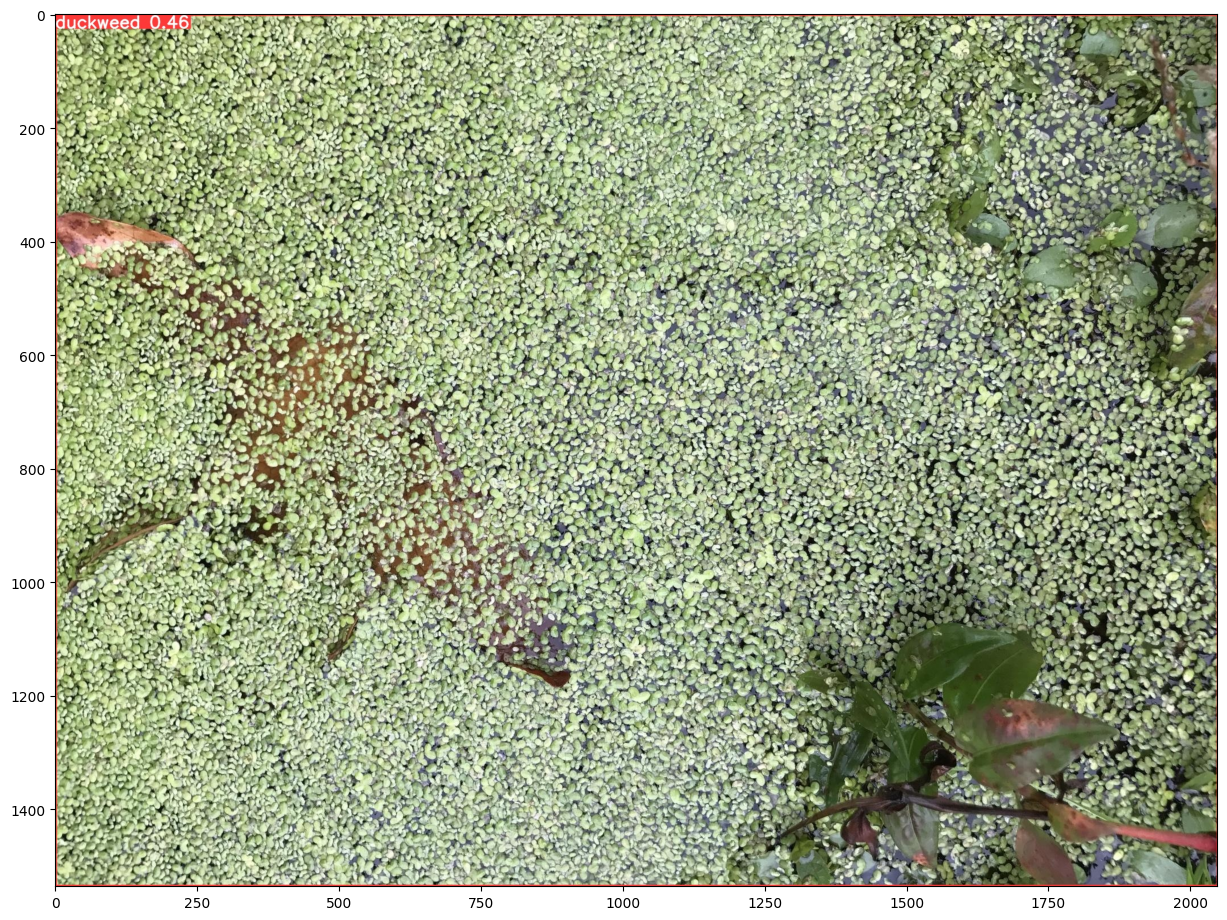

In [ ]:
import PIL.Image

# randomly plot one of the detections
detections_dir = predictions_path + "best_checkpoint"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]

random_detection_image = PIL.Image.open(random.choice(detection_images))
plt.imshow(np.array(random_detection_image))

## 6. Evaluate the model
Although `train.py` keeps logging mAP constantly, `val.py` can also get final metrics.

In [ ]:
%cd /content/yolov5/

# Path for the checkpoint
best_checkpoint = "yolov5m_initialdataset"
predictions_path = "/content/yolov5/predictions/"

!python val.py --weights "$checkpoints_path/$best_checkpoint/weights/best.pt" --data data.yaml --task test --project "$predictions_path" --name best_checkpoint

/content/yolov5
val: data=data.yaml, weights=['/content/gdrive/Shareddrives/Recycling Rush - Datasets ♻️/experiments/yolov5s/yolov5m_initialdataset/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=/content/yolov5/predictions/, name=best_checkpoint, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-38-g4362372 Python-3.8.16 torch-1.13.1+cu117 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
100% 755k/755k [00:00<00:00, 148MB/s]
test: Scanning /content/duckweed_dataset/test/labels... 331 images, 0 backgrounds, 2 corrupt: 100% 331/331 [00:00<00:00, 1918.76it/s]
test: WARNING ⚠️ /content/duckweed_dataset/test/images/2051.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.009       1.018]


The point of downloading YOLO v5 from Github is that it comes with many scripts for training, evaluating, and ploting results. For instance, the repository includes a great utility function `plot_results()` that allows you to evaluate your model performance on the last training run:

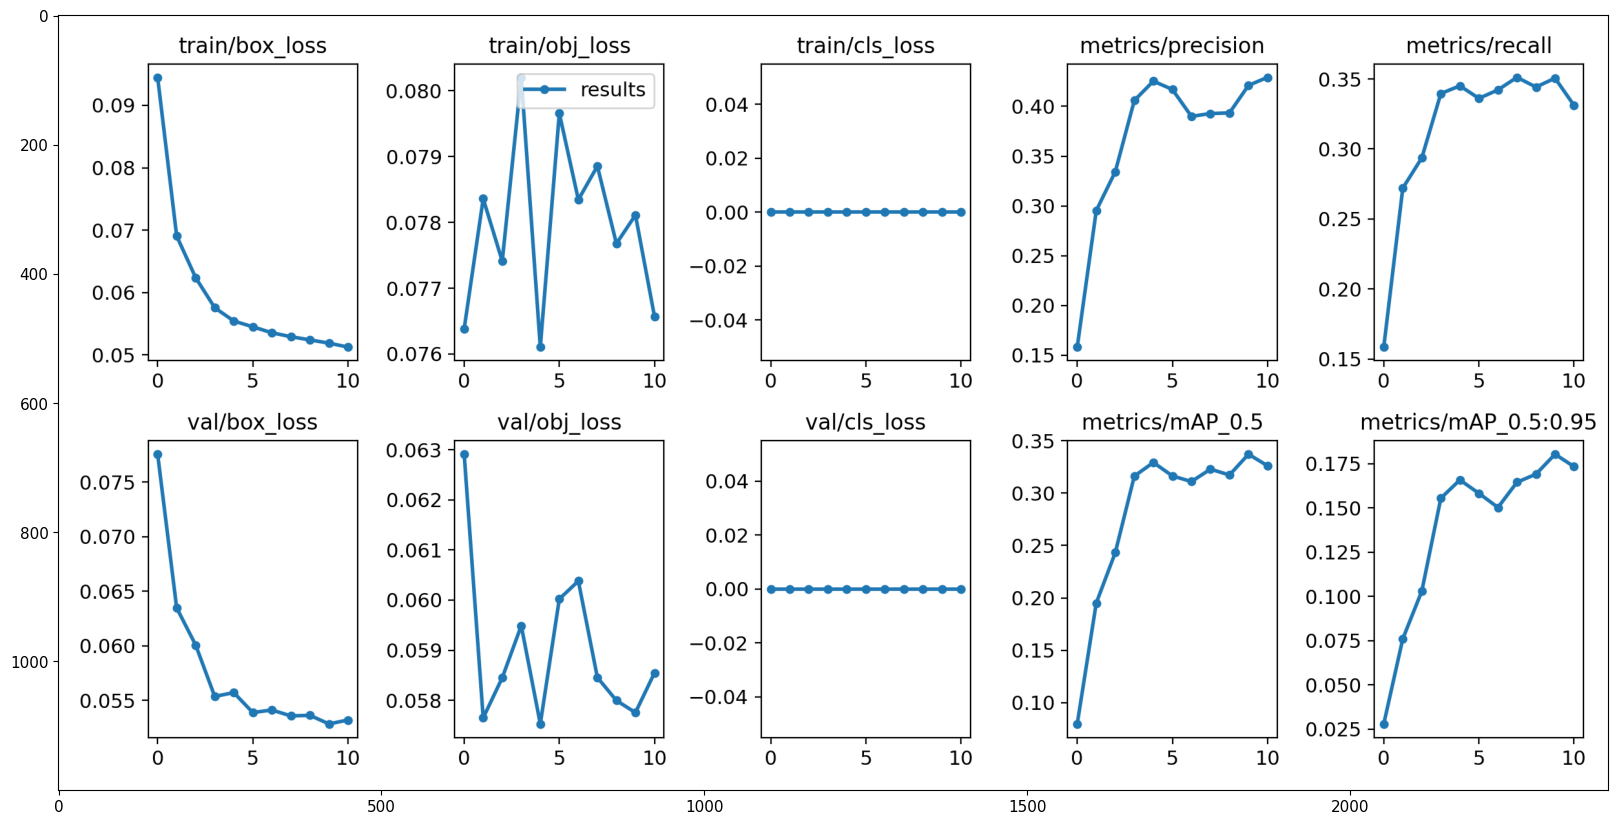

In [ ]:
from utils.plots import *
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.rcParams["figure.figsize"] = (20,20)

# plot_results(checkpoints_path+"/"+best_checkpoint+"/results.csv")

img = mpimg.imread(checkpoints_path+"/"+best_checkpoint+"/results.png")
imgplot = plt.imshow(img)
plt.show()

## 7. Inference with a video


In [ ]:
%cd /content/yolov5/

# Path for the checkpoint
best_checkpoint = "yolov5m_initialdataset"
predictions_path = "/content/yolov5/predictions/"

# Path for the checkpoints
checkpoints_path = "/content/gdrive/Shareddrives/Recycling Rush - Datasets ♻️/experiments/yolov5s"

if not os.path.exists(predictions_path):
  !mkdir "$predictions_path"

!python detect.py --source "/content/video2.mp4" --weights "$checkpoints_path/$best_checkpoint/weights/best.pt" --project "$predictions_path" --name best_checkpoint

/content/yolov5
detect: weights=['/content/gdrive/Shareddrives/Recycling Rush - Datasets ♻️/experiments/yolov5s/yolov5m_initialdataset/weights/best.pt'], source=/content/video2.mp4, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=/content/yolov5/predictions/, name=best_checkpoint, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-40-gb2a0f1c Python-3.8.16 torch-1.13.1+cu117 CUDA:0 (A100-SXM4-40GB, 40536MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
video 1/1 (1/3136) /content/video2.mp4: 384x640 3 duckweeds, 18.1ms
video 1/1 (2/3136) /content/video2.mp4: 384x640 3 duckweeds, 10.8ms
video 1/1 (3/3136) /content/video2.mp4: 384x640 3 duckweeds, 10.8ms
video 